In [536]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [537]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [538]:
def perspective_transformer():
    global src, dst, M, Minv

    # Define the perspective transformation area
    img_width = 1280
    img_height = 720

    bot_width = .76 # percent of bottom
    mid_width = .17 #.17
    height_pct = .66 #.66
    bottom_trim = .935
    src = np.float32([
        [530, 350],
        [800, 350],
        [1230, img_height*0.9],
        [180, img_height*0.9]
    ])
    # src = np.float32([
    #     [585, 350],
    #     [800, 350],
    #     [1250, img_height*bottom_trim],
    #     [290, img_height*bottom_trim]
    # ])
    
    offset = img_width*.2
    
    dst = np.float32([
        [offset, 0],
        [img_width-offset, 0],
        [img_width-offset, img_height],
        [offset, img_height]
    ])
    
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

In [539]:
# Threshold pipeline
# 

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2+sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    return mag_binary

def dir_thresh(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradient_direction = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gradient_direction)
    dir_binary[(gradient_direction>=thresh[0])&(gradient_direction<=thresh[1])] = 1
    
    return dir_binary

def color_thresh(img, s_thresh=(0,255), v_thresh=(0,255)):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel>=s_thresh[0]) & (s_channel<=s_thresh[1])] = 1
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel>=v_thresh[0]) & (v_channel<=v_thresh[1])] = 1   
    
    c_binary = np.zeros_like(s_channel)
    c_binary[(s_binary==1) & (v_binary==1)] = 1
    
    return c_binary
    

def thresh_pipeline(img, gradx_thresh=(0,255), grady_thresh=(0,255), s_thresh=(0, 255), v_thresh=(0, 255)):
    
    gradx = abs_sobel_thresh(img, orient='x', thresh=gradx_thresh)
    grady = abs_sobel_thresh(img, orient='y', thresh=grady_thresh)
    c_binary = color_thresh(img, s_thresh=s_thresh, v_thresh=v_thresh)
    
    
    # Combine these thresholded binary images
    thresh_binary = np.zeros_like(img[:,:,0])
    thresh_binary[(gradx==1) & (grady==1) | (c_binary==1)] = 255
#     thresh_binary[c_binary==1] = 255
#     thresh_binary[(sxbinary==1)|(s_binary==1)] = 1 
    
    return thresh_binary

In [540]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped



In [541]:
def sliding_windows_search(img):
    # input: binary warped image
    # 5. Detect lane pixels and fit to find the lane boundary.

    # binary_warped = mpimg.imread('test_images/warped-example.jpg')
    binary_warped = img.astype('uint8')

    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0]/2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return left_fit, right_fit, out_img

In [542]:
def lane_tracking(img, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!

    # Now we already have left_fit, right_fit
    
    binary_warped = img.astype('uint8')

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    window_img = np.zeros_like(out_img)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) 
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) 
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
   
    
    return left_fit, right_fit, result


In [543]:
def cal_curvature(ploty, left_fitx, right_fitx):
    
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    global ym_per_pix, xm_per_pix
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/505/1.2054/0.97 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
#     print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m
    
    # Calculate the offset of the car on the road
    
    lane_center = (left_fitx[-1]+right_fitx[-1])/2
        
    center_diff = (640-lane_center)*xm_per_pix
    
    return left_curverad, right_curverad, center_diff

In [544]:
def lane_mask(img_undist, binary_warped, Minv, ploty, left_fitx, right_fitx):
    # 7. Warp the detected lane boundaries back onto the original image.

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    middle_x = (left_fitx + right_fitx)/2
    middle_pts = np.transpose(np.vstack((middle_x, ploty))).astype(np.int32)
    
#     print(middle_pts.shape)
#     print(middle_pts)
#     plt.plot((left_fitx+right_fitx)/2, ploty, color='yellow')
    cv2.polylines(color_warp, np.int32([middle_pts]), False, (0, 0, 255), thickness=10)
    cv2.polylines(color_warp, np.int32([pts_left]), False, (0, 0, 255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), False, (0, 0, 255), thickness=15)
    
    cv2.arrowedLine(color_warp, (640, 719), (640,690), (255,0,255), 5, tipLength=0.25)
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_undist.shape[1], img_undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_undist, 1, newwarp, 0.3, 0)
    
    
    debug_canvas = (np.dstack((binary_warped, binary_warped, binary_warped))*255).astype(np.uint8)
    debug_result = cv2.addWeighted(debug_canvas, 1, color_warp, 0.4, 0)
    
    return result


In [545]:
def lane_quality(ploty, left_fitx, right_fitx):

    
    lane_width = (right_fitx - left_fitx)
    lane_width_mean = np.mean(lane_width)*xm_per_pix
    lane_width_var = np.var(lane_width)
    
    return lane_width_mean, lane_width_var


In [546]:
def lane_finding(img_orig):
    
    # 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.        
    # mtx, dist are global variables
    
    # 2. Apply a distortion correction to raw images.
    img_undist = cv2.undistort(img_orig, mtx, dist, None, mtx)
    
    # 3. Use color transforms, gradients, etc., to create a thresholded binary image.
    img_thresh = thresh_pipeline(img_undist, gradx_thresh=(25,255), grady_thresh=(10,255), s_thresh=(100, 255), v_thresh=(0, 255))
    
    # 4. Apply a perspective transform to rectify binary image ("birds-eye view").
    # src, dst, M, Minv are global variables

    img_birdeye = warper(img_thresh, src, dst)
    img_birdeye_color = warper(img_undist, src, dst)
    
    # 5. Detect lane pixels and fit to find the lane boundary. 
        
    if (not line_l.detected) or (not line_r.detected):
        # Run a sliding windows search
        left_fit, right_fit, img_search = sliding_windows_search(img_birdeye)
        
        cv2.putText(img_search, 'Searching', 
            (550, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)
  
    else:
#         print(line_l.recent_xfitted[-1][0], line_r.recent_xfitted[-1][0])
        
        left_fit, right_fit, img_search = lane_tracking(img_birdeye, 
                                                        line_l.recent_xfitted[-1][0], 
                                                        line_r.recent_xfitted[-1][0]) 
        cv2.putText(img_search, 'Tracking', 
                    (550, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)
    
    line_l.current_fit = [left_fit]
    line_r.current_fit = [right_fit]

    line_l.bestx = None
    line_r.bestx = None
    
    line_l.recent_xfitted.append([left_fit])
    line_r.recent_xfitted.append([right_fit])  

    if len(line_l.recent_xfitted)>1:
        
        line_l.best_fit = np.mean(np.array(line_l.recent_xfitted[-20:-1]),
                                axis=0) 
        line_r.best_fit = np.mean(np.array(line_r.recent_xfitted[-20:-1]),
                                axis=0)    
    else:
        line_l.best_fit = line_l.recent_xfitted[-1][0]
        line_r.best_fit = line_r.recent_xfitted[-1][0]  
            
    # 6. Determine the curvature of the lane and vehicle position with respect to center.
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_birdeye.shape[0]-1, img_birdeye.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad, right_curverad, center_diff = cal_curvature(ploty, left_fitx, right_fitx)
    lane_width_mean, lane_width_var = lane_quality(ploty, left_fitx, right_fitx)
    
    # Sanity chec
#     print(left_fit)
#     print(line_l.best_fit)
    
    line_l.diffs = left_fit - line_l.best_fit
    
    line_r.diffs = right_fit - line_r.best_fit
    
#     print(np.sum(line_l.diffs**2)+np.sum(line_r.diffs))
    
    lane_continue = np.sum(line_l.diffs**2)+np.sum(line_r.diffs)
    
    if (not 3<lane_width_mean<5) or (lane_width_var>500) or (lane_continue>6000):
        
        line_l.detected = False
        line_r.detected = False
        
        del line_l.recent_xfitted[-1]
        
        del line_r.recent_xfitted[-1]
        
        left_fit, right_fit = line_l.best_fit[0], line_r.best_fit[0]
        
        cv2.putText(img_search, '------', 
            (550, 350), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 5)
        
        cv2.putText(img_search, 'Keeping', 
            (550, 450), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,0), 5)
                
    else:
#         left_fit, right_fit = line_l.current_fit[0], line_r.current_fit[0]
        line_l.detected = True
        line_r.detected = True

        line_l.best_fit = np.mean(np.array(line_l.recent_xfitted[-20:]),
                                axis=0) 
        line_r.best_fit = np.mean(np.array(line_r.recent_xfitted[-20:]),
                                axis=0)
    

    
    # Recalculate the curvature and lane_width
#     print(left_fit, right_fit)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    left_curverad, right_curverad, center_diff = cal_curvature(ploty, left_fitx, right_fitx)
    lane_width_mean, lane_width_var = lane_quality(ploty, left_fitx, right_fitx)
        

    # 7. Warp the detected lane boundaries back onto the original image.
    result = lane_mask(img_undist, img_birdeye, Minv, ploty, left_fitx, right_fitx)
    cv2.putText(result, 'Radius of Curvature (L) = '+str(round(left_curverad, 1)/100)+'(m)', 
                (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Radius of Curvature (R) = '+str(round(right_curverad, 1))+'(m)', 
                (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Vehicle is '+str(round(center_diff, 2))+'(m) off center', 
                (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    cv2.putText(result, 'Lane width '+str(round(lane_width_mean, 2))+'(m) Var:'+str(round(lane_width_var)), 
                (50, 200), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    canvas = np.zeros([960,1280,3], dtype=np.uint8)
    
    canvas[0:720, 0:1280, :] = result   
        
    ## Plot 1 
#     color_thresh_binary = np.dstack(( np.zeros_like(img_thresh), img_thresh, np.zeros_like(img_thresh) ))
#     color_thresh_binary = (color_thresh_binary*255).astype(np.uint8)
    img_debug = img_thresh
    color_debug = np.dstack(( img_debug, img_debug, img_debug ))
#     color_debug = (color_debug*255).astype(np.uint8)
    cv2.polylines(color_debug, np.int32([src]), True, (0, 255, 0), thickness=4)
    plot1 = cv2.resize(color_debug, (426, 240))
    
    ## Plot 3: bird eye view (binary) 
    img_debug = img_birdeye
    color_debug = np.dstack(( img_debug, img_debug, img_debug ))
#     color_debug = (color_debug*255).astype(np.uint8)
    plot3 = cv2.resize(color_debug, (426, 240))
    
    ## Plot 4: the searching process
    plot4 = img_search
    left_pts = np.transpose(np.vstack((left_fitx, ploty))).astype(np.int32)    
    right_pts = np.transpose(np.vstack((right_fitx, ploty))).astype(np.int32)
#     print(left_pts.shape);print(left_pts)
#     print(right_pts.shape);print(right_pts)
    cv2.polylines(plot4, np.int32([left_pts]), False, (255, 255, 0), thickness=5)
    cv2.polylines(plot4, np.int32([right_pts]), False, (255, 255, 0), thickness=5)
    plot4 = cv2.resize(img_search, (426, 240))
    
    ## Plot 2: bird eye view (color)
    cv2.polylines(img_birdeye_color, np.int32([dst]), True, (0, 255, 0), thickness=4)
    plot2 = cv2.resize(img_birdeye_color, (426, 240))
    
    # Plot the three contents
    canvas[720:960, 0:426, :] = plot1
    canvas[720:960, 427:427+426, :] = plot2
    canvas[720:960, -427:-1, :] = plot4
    
    return canvas


In [547]:
# Read in the saved objpoints and imgpoints
import pickle
global mtx, dist
calibration_pickle = pickle.load( open( "./calibration_pickle.p", "rb" ) )
mtx = calibration_pickle["mtx"]
dist = calibration_pickle["dist"]

In [548]:
perspective_transformer()
print('src: {}; dst:{}'.format(src, dst))

src: [[ 530.  350.]
 [ 800.  350.]
 [1230.  648.]
 [ 180.  648.]]; dst:[[ 256.    0.]
 [1024.    0.]
 [1024.  720.]
 [ 256.  720.]]


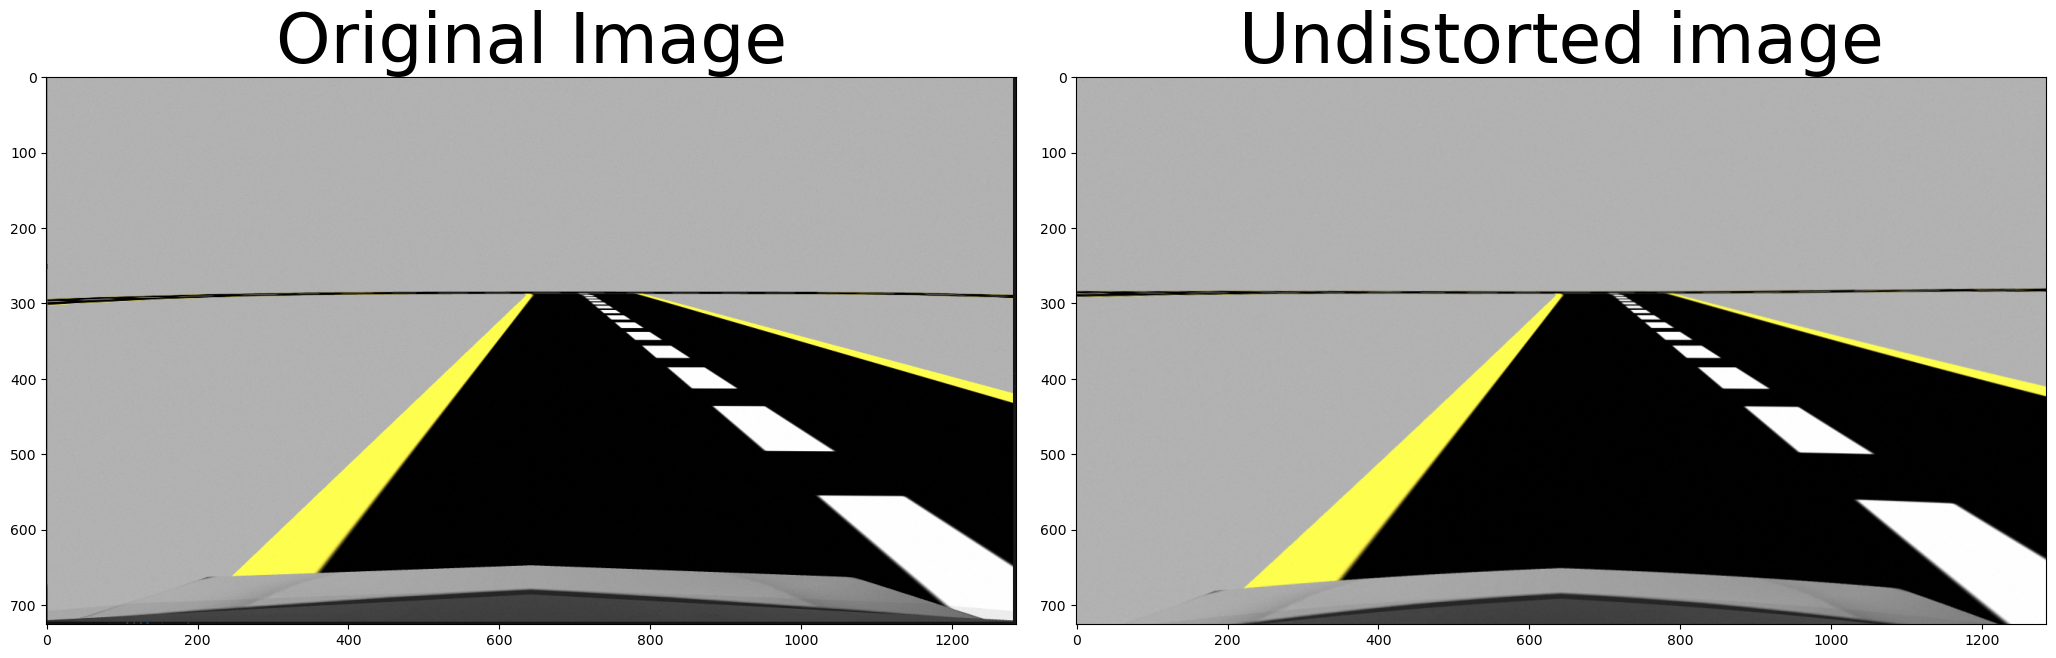

In [549]:
# Undistort image
img_orig = mpimg.imread('./frame.png')

img_undist = cv2.undistort(img_orig, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Original Image', fontsize=50)
ax1.imshow(img_orig)
ax2.set_title('Undistorted image', fontsize=50)
ax2.imshow(img_undist)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

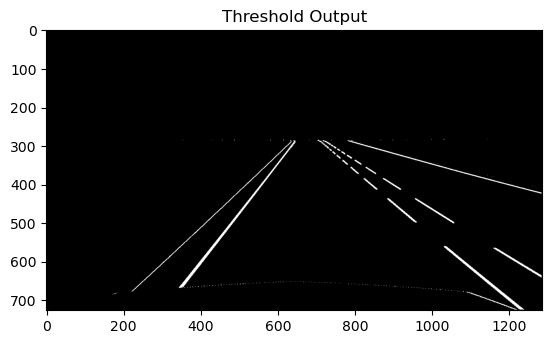

In [550]:
img_thresh = img_thresh = thresh_pipeline(img_undist, 
                                          gradx_thresh=(25,255), 
                                          grady_thresh=(10,255), 
                                          s_thresh=(100, 255), 
                                          v_thresh=(0, 255))
plt.imshow(img_thresh, cmap='gray'); plt.title('Threshold Output'); plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


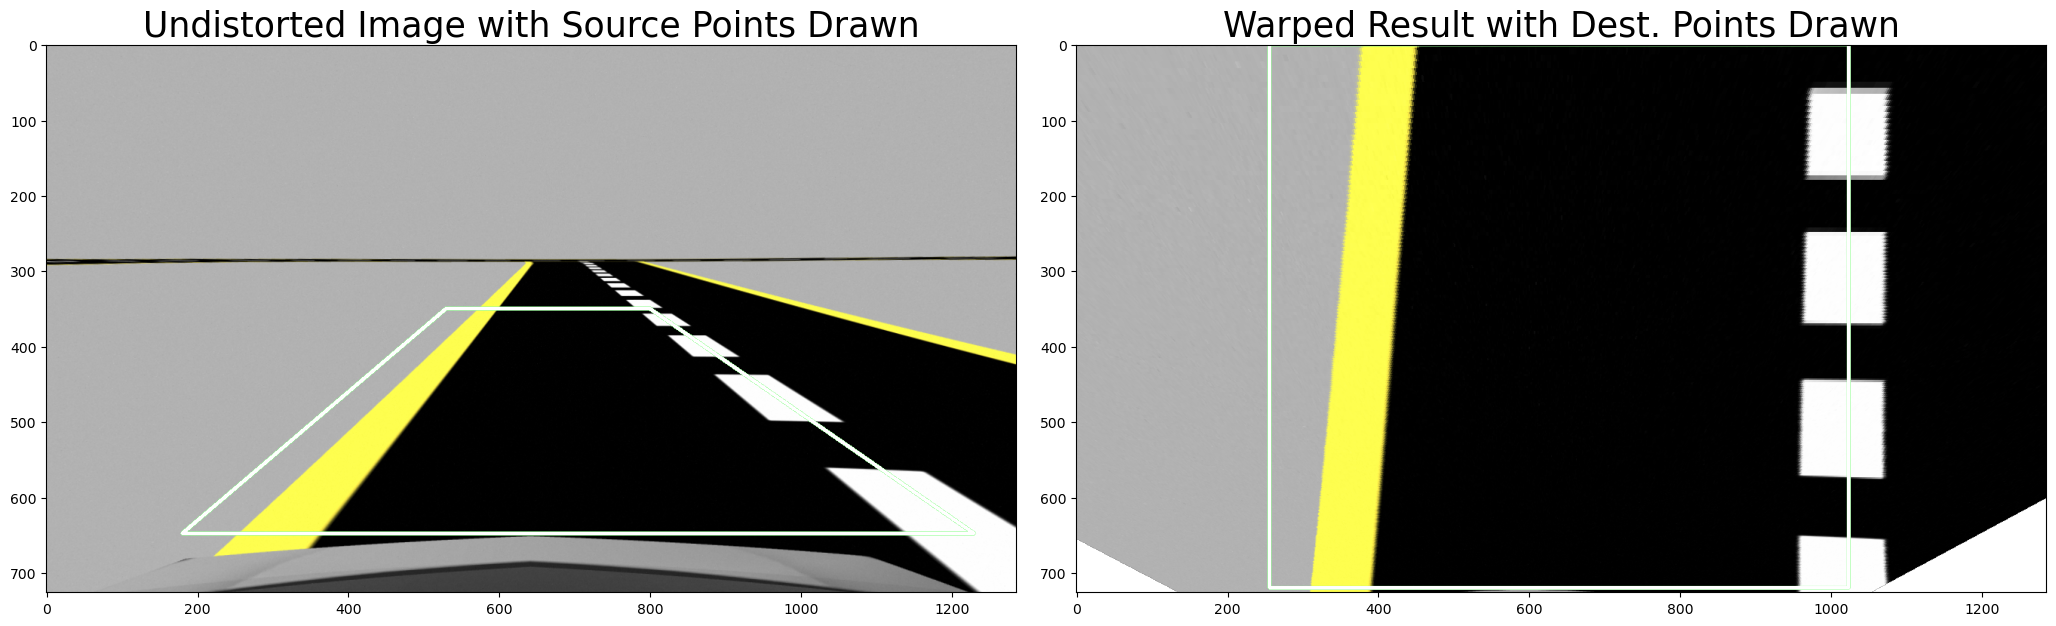

In [551]:
img_birdeye_color = warper(img_undist, src, dst)

cv2.polylines(img_undist, np.int32([src]), 
              True, (0, 255, 0), thickness=4)
cv2.polylines(img_birdeye_color, np.int32([dst]), 
              True, (0, 255, 0), thickness=4)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Undistorted Image with Source Points Drawn', fontsize=25)
ax1.imshow(img_undist)
ax2.set_title('Warped Result with Dest. Points Drawn', fontsize=25)
ax2.imshow(img_birdeye_color)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

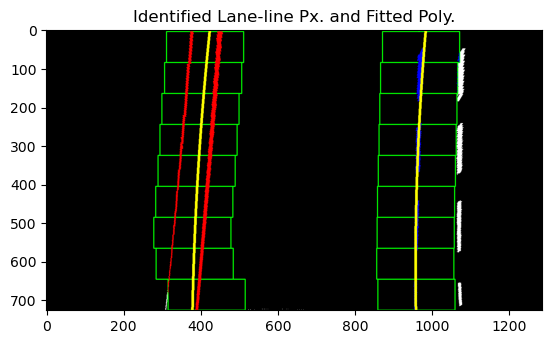

In [552]:
img_birdeye = warper(img_thresh, src, dst)
left_fit, right_fit, img_search = sliding_windows_search(img_birdeye)

ploty = np.linspace(0, img_birdeye.shape[0]-1, img_birdeye.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

left_pts = np.transpose(np.vstack((left_fitx, ploty))).astype(np.int32)    
right_pts = np.transpose(np.vstack((right_fitx, ploty))).astype(np.int32)

cv2.polylines(img_search, np.int32([left_pts]), False, (255, 255, 0), thickness=5)
cv2.polylines(img_search, np.int32([right_pts]), False, (255, 255, 0), thickness=5)

plt.imshow(img_search)
plt.title('Identified Lane-line Px. and Fitted Poly.')
plt.show()

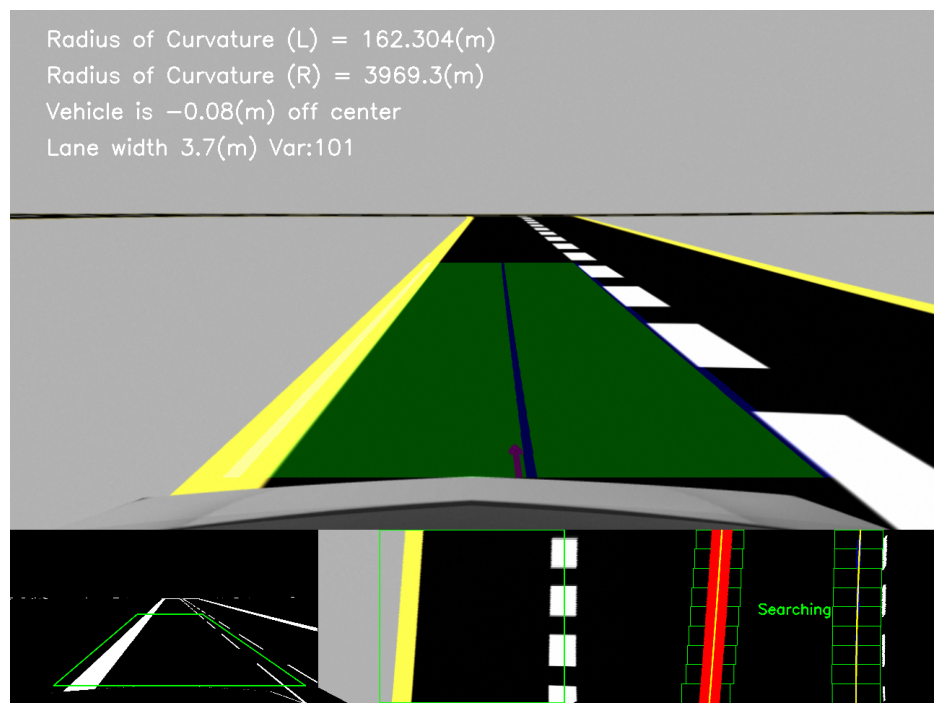

In [553]:
line_l = Line()
line_r = Line()

# Make a list of test images
test_files = 'frame.png'
images = glob.glob(test_files)

# Step through the list and search for chessboard corners
for fname in images:
    
    line_l.detected = False
    line_r.detected = False
    
    img_orig = cv2.imread(fname)
    img_orig = cv2.resize(img_orig, (1280, 720))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
#     img_orig = mpimg.imread('test_images/straight_lines.jpg') # 'straight_lines2.jpg'
    img_output = lane_finding(img_orig)
    plt.figure(figsize=(12,9))
    plt.imshow(img_output); plt.axis('off'); plt.show()

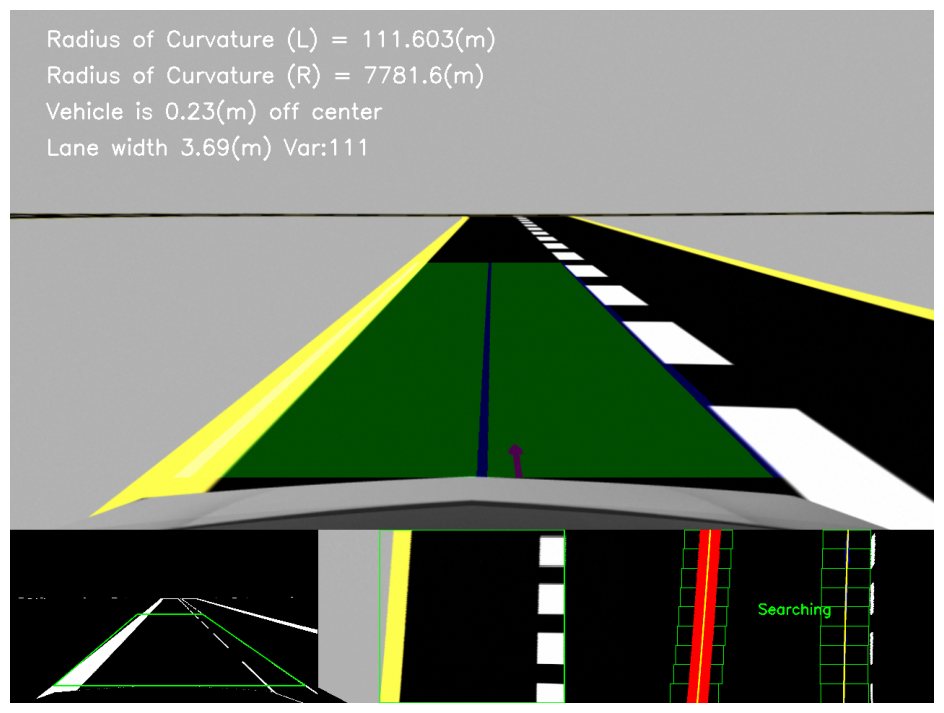

In [554]:
line_l = Line()
line_r = Line()

# Make a list of test images
test_files = 'frame1.png'
images = glob.glob(test_files)

# Step through the list and search for chessboard corners
for fname in images:
    
    line_l.detected = False
    line_r.detected = False
    
    img_orig = cv2.imread(fname)
    img_orig = cv2.resize(img_orig, (1280, 720))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
#     img_orig = mpimg.imread('test_images/straight_lines.jpg') # 'straight_lines2.jpg'
    img_output = lane_finding(img_orig)
    plt.figure(figsize=(12,9))
    plt.imshow(img_output); plt.axis('off'); plt.show()

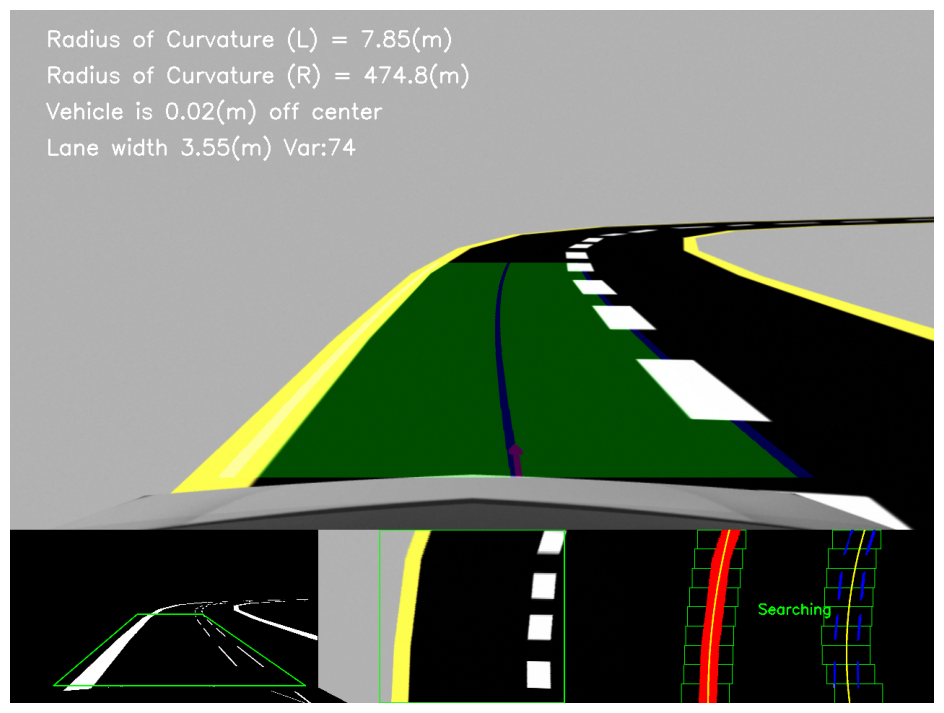

In [555]:
line_l = Line()
line_r = Line()

# Make a list of test images
test_files = 'frame2.png'
images = glob.glob(test_files)

# Step through the list and search for chessboard corners
for fname in images:
    
    line_l.detected = False
    line_r.detected = False
    
    img_orig = cv2.imread(fname)
    img_orig = cv2.resize(img_orig, (1280, 720))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
#     img_orig = mpimg.imread('test_images/straight_lines.jpg') # 'straight_lines2.jpg'
    img_output = lane_finding(img_orig)
    plt.figure(figsize=(12,9))
    plt.imshow(img_output); plt.axis('off'); plt.show()

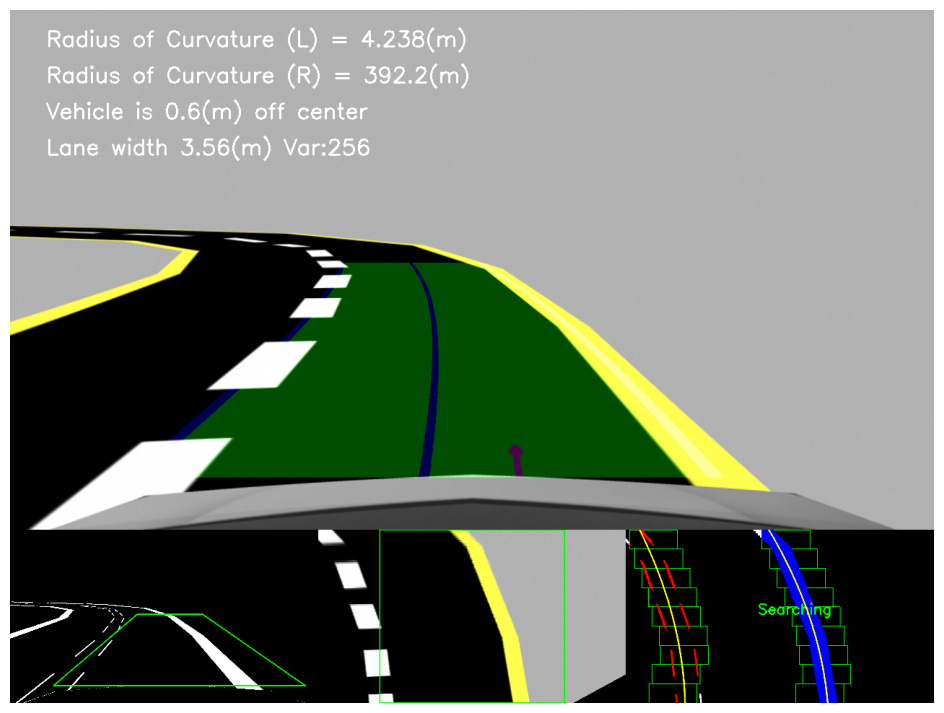

In [556]:
line_l = Line()
line_r = Line()

# Make a list of test images
test_files = 'frame3.png'
images = glob.glob(test_files)

# Step through the list and search for chessboard corners
for fname in images:
    
    line_l.detected = False
    line_r.detected = False
    
    img_orig = cv2.imread(fname)
    img_orig = cv2.resize(img_orig, (1280, 720))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
#     img_orig = mpimg.imread('test_images/straight_lines.jpg') # 'straight_lines2.jpg'
    img_output = lane_finding(img_orig)
    plt.figure(figsize=(12,9))
    plt.imshow(img_output); plt.axis('off'); plt.show()

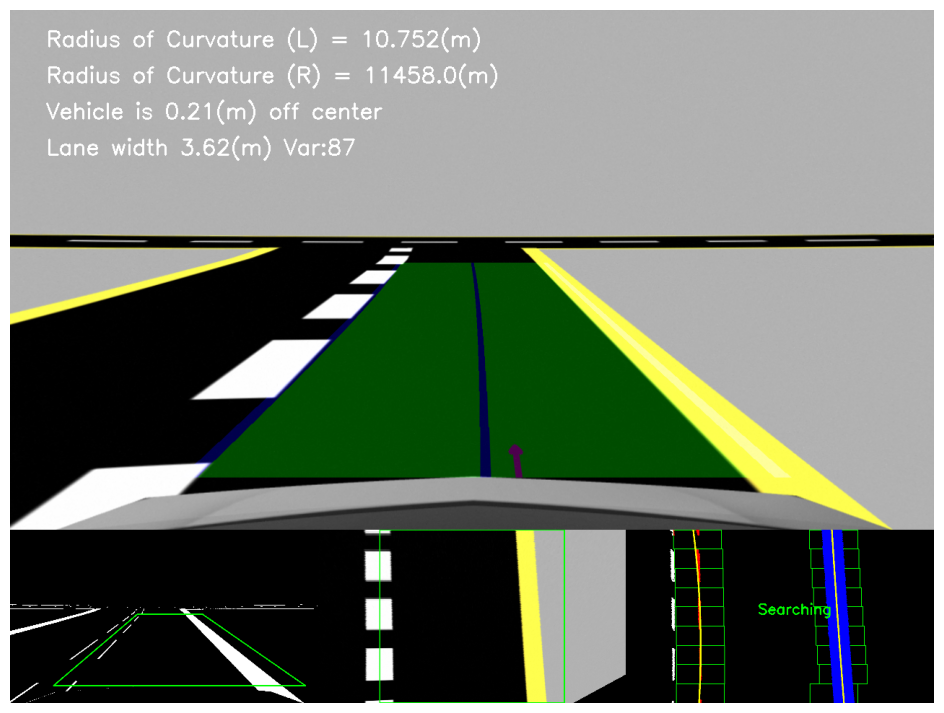

In [558]:
line_l = Line()
line_r = Line()

# Make a list of test images
test_files = 'frame6.png'
images = glob.glob(test_files)

# Step through the list and search for chessboard corners
for fname in images:
    
    line_l.detected = False
    line_r.detected = False
    
    img_orig = cv2.imread(fname)
    img_orig = cv2.resize(img_orig, (1280, 720))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
#     img_orig = mpimg.imread('test_images/straight_lines.jpg') # 'straight_lines2.jpg'
    img_output = lane_finding(img_orig)
    plt.figure(figsize=(12,9))
    plt.imshow(img_output); plt.axis('off'); plt.show()